In [1]:
from IPython.display import display, HTML

display(HTML('''<script>
    function ClickConnect(){
        console.log("clicked on connect button");
        document.querySelector("colab-connect-button").click();
    }
    setInterval(ClickConnect, 60000);
</script>'''))

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, top_k_accuracy_score
import seaborn as sns
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.OxfordIIITPet(root='data', split='trainval',
                                       target_types='category', transform=transform, download=True)
test_dataset = datasets.OxfordIIITPet(root='data', split='test',
                                      target_types='category', transform=transform, download=True)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(set(train_dataset._labels))  # 37

100%|██████████| 792M/792M [00:45<00:00, 17.4MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 7.35MB/s]


In [5]:
base_dir = "data/oxford-iiit-pet/images"
image_files = [f for f in os.listdir(base_dir) if f.lower().endswith('.jpg')]
labels = [f.split('_')[0].lower() for f in image_files]

df = pd.DataFrame({
    'filename': image_files,
    'label': labels
})

class_names = sorted(df['label'].unique())

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=vgg_preprocess
)

val_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess)
test_datagen = ImageDataGenerator(preprocessing_function=vgg_preprocess)

train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=base_dir, x_col='filename', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='sparse', batch_size=BATCH_SIZE
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, directory=base_dir, x_col='filename', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='sparse', batch_size=BATCH_SIZE, shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df, directory=base_dir, x_col='filename', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='sparse', batch_size=BATCH_SIZE, shuffle=False
)

Found 5320 validated image filenames belonging to 35 classes.
Found 592 validated image filenames belonging to 35 classes.
Found 1478 validated image filenames belonging to 35 classes.


In [7]:
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(base_model_fn, input_shape=(224, 224, 3), num_classes=37, preprocess_fn=None, train_base=False):
    base_input = Input(shape=input_shape)
    x = preprocess_fn(base_input) if preprocess_fn else base_input

    base_model = base_model_fn(weights='imagenet', include_top=False, input_tensor=x)
    base_model.trainable = train_base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
def train_model(model, train_gen, val_gen, model_name, epochs=10):
    checkpoint = ModelCheckpoint(f'{model_name}.keras', save_best_only=True, monitor='val_accuracy', mode='max')
    earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, earlystop],
        verbose=1
    )

    return model, history

In [9]:
num_classes = len(class_names)

vgg16_model = build_model(VGG16, num_classes=num_classes, preprocess_fn=vgg_preprocess)
vgg16_model, vgg16_history = train_model(vgg16_model, train_generator, val_generator, 'vgg16_model')

test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 112s 581ms/step - accuracy: 0.0288 - loss: 22.6491 - val_accuracy: 0.0507 - val_loss: 15.1299
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 114s 497ms/step - accuracy: 0.0538 - loss: 17.7402 - val_accuracy: 0.1047 - val_loss: 11.3822
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 493ms/step - accuracy: 0.0824 - loss: 14.6906 - val_accuracy: 0.1774 - val_loss: 8.8540
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 494ms/step - accuracy: 0.1118 - loss: 13.0207 - val_accuracy: 0.2483 - val_loss: 6.9886
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 83s 495ms/step - accuracy: 0.1607 - loss: 10.9311 - val_accuracy: 0.3176 - val_loss: 5.7301
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 486ms/step - accuracy: 0.1992 - loss: 9.7434 - val_accuracy: 0.3868 - val_loss: 4.7957
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 493ms/step - accuracy: 0.2303 - loss: 8.7886 - val_accuracy: 0.4375 - val_loss: 4.1557
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 82s 488ms/step - accuracy: 0.2565 

In [10]:
vgg19_model = build_model(VGG19, num_classes=num_classes, preprocess_fn=vgg_preprocess)
vgg19_model, vgg19_history = train_model(vgg19_model, train_generator, val_generator, 'vgg19_model')

test_loss, test_acc = vgg19_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 96s 551ms/step - accuracy: 0.0476 - loss: 20.4968 - val_accuracy: 0.0659 - val_loss: 13.5990
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 87s 521ms/step - accuracy: 0.0576 - loss: 15.9902 - val_accuracy: 0.1081 - val_loss: 10.3904
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 86s 512ms/step - accuracy: 0.0961 - loss: 13.2875 - val_accuracy: 0.1605 - val_loss: 8.0859
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 86s 512ms/step - accuracy: 0.1345 - loss: 11.2239 - val_accuracy: 0.2280 - val_loss: 6.4384
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 86s 517ms/step - accuracy: 0.1803 - loss: 9.7721 - val_accuracy: 0.3091 - val_loss: 5.2185
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 87s 521ms/step - accuracy: 0.2291 - loss: 8.4951 - val_accuracy: 0.3851 - val_loss: 4.3401
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 139s 505ms/step - accuracy: 0.2513 - loss: 7.4978 - val_accuracy: 0.4662 - val_loss: 3.6988
Epoch 8/10
167/167 ━━━━━━

In [11]:
resnet_train_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=resnet_preprocess
)

resnet_val_gen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

resnet_train_generator = resnet_train_gen.flow_from_dataframe(
    train_df, directory=base_dir, x_col='filename', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='sparse', batch_size=BATCH_SIZE
)

resnet_val_generator = resnet_val_gen.flow_from_dataframe(
    val_df, directory=base_dir, x_col='filename', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='sparse', batch_size=BATCH_SIZE, shuffle=False
)

resnet_model = build_model(ResNet50, num_classes=num_classes, preprocess_fn=resnet_preprocess)
resnet_model, resnet_history = train_model(resnet_model, resnet_train_generator, resnet_val_generator, 'resnet_model')

test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

Found 5320 validated image filenames belonging to 35 classes.
Found 592 validated image filenames belonging to 35 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 101s 527ms/step - accuracy: 0.0568 - loss: 4.0573 - val_accuracy: 0.2736 - val_loss: 2.6413
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 77s 464ms/step - accuracy: 0.2351 - loss: 2.7438 - val_accuracy: 0.4865 - val_loss: 1.9052
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 456ms/step - accuracy: 0.3747 - loss: 2.1122 - val_accuracy: 0.5828 - val_loss: 1.5057
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 467ms/step - accuracy: 0.4872 - loss: 1.7423 - val_accuracy: 0.6318 - val_loss: 1.2869
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 465ms/step - accuracy: 0.5509 - loss: 1.4948 - val_accuracy: 0.6672 - val_loss: 1.1506
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 77s 463ms/step - accuracy: 0.6016 - loss: 1.3491 - val_accuracy: 0.6875 - val_loss: 1.0494
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 76s 456ms/step - accuracy: 0.6323 - loss: 1.2242 - val_accuracy: 0.7078 - val_loss: 0.9734
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 469ms/step - accuracy: 0.6620 - loss: 

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step


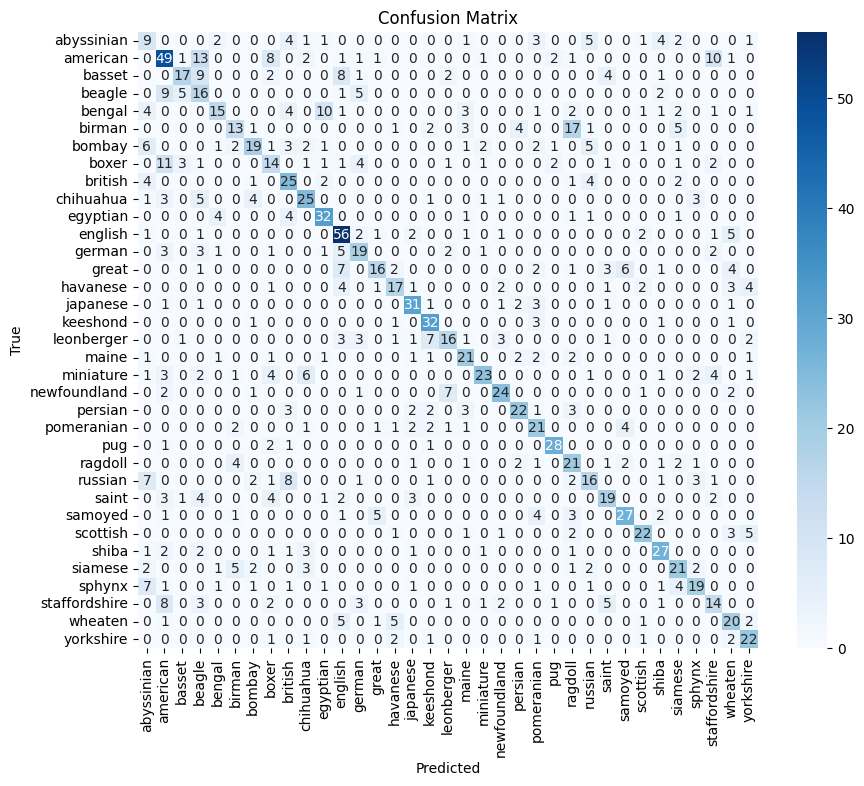

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_generator.classes
y_pred = vgg16_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Found 5752 validated image filenames belonging to 2 classes.
Found 1438 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 53s 241ms/step - accuracy: 0.6617 - loss: 0.6289 - val_accuracy: 0.6662 - val_loss: 0.6073
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 159ms/step - accuracy: 0.6741 - loss: 0.5950 - val_accuracy: 0.6794 - val_loss: 0.5944
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 162ms/step - accuracy: 0.6804 - loss: 0.5985 - val_accuracy: 0.6815 - val_loss: 0.5879
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.6902 - loss: 0.5780 - val_accuracy: 0.6718 - val_loss: 0.5932
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.6916 - loss: 0.5756 - val_accuracy: 0.6947 - val_loss: 0.5798
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.6878 - loss: 0.5831
Validation Accuracy: 0.6947
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step


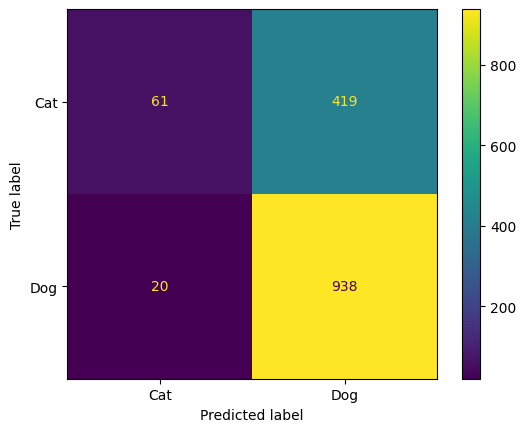

In [13]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cat_classes = [c.replace(' ', '_').lower() for c in [
    'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair',
    'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll',
    'Russian Blue', 'Siamese', 'Sphynx'
]]

dog_classes = [d.replace(' ', '_').lower() for d in [
    'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle',
    'Boxer', 'Chihuahua', 'English Cocker Spaniel', 'English Setter',
    'German Shorthaired Pointer', 'Great Pyrenees', 'Havanese', 'Japanese Chin',
    'Keeshond', 'Leonberger', 'Miniature Pinscher', 'Newfoundland',
    'Pomeranian', 'Pug', 'Saint Bernard', 'Samoyed', 'Scottish Terrier',
    'Shiba Inu', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier'
]]

image_dir = 'data/oxford-iiit-pet/images'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

data = []
for file in image_files:
    breed = file.rsplit('_', 1)[0].lower()
    if breed in cat_classes:
        label = 'cat'
    elif breed in dog_classes:
        label = 'dog'
    else:
        continue
    data.append({'filename': file, 'label': label})

df = pd.DataFrame(data)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

binary_model = Model(inputs=base_model.input, outputs=output)
binary_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

binary_model.fit(train_gen, validation_data=val_gen, epochs=5)

loss, accuracy = binary_model.evaluate(val_gen)
print(f"Validation Accuracy: {accuracy:.4f}")

val_gen.reset()
y_pred_probs = binary_model.predict(val_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot()
plt.show()


In [14]:
from sklearn.metrics import top_k_accuracy_score


y_true = test_generator.classes
y_pred = vgg16_model.predict(test_generator)

top_3_acc = top_k_accuracy_score(y_true, y_pred, k=3, labels=np.arange(num_classes))
top_5_acc = top_k_accuracy_score(y_true, y_pred, k=5, labels=np.arange(num_classes))

print(f"Top-3 Accuracy: {top_3_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step
Top-3 Accuracy: 0.800405953991881
Top-5 Accuracy: 0.8903924221921515


In [15]:
y_pred = vgg19_model.predict(test_generator)

top_3_acc = top_k_accuracy_score(y_true, y_pred, k=3, labels=np.arange(num_classes))
top_5_acc = top_k_accuracy_score(y_true, y_pred, k=5, labels=np.arange(num_classes))

print(f"Top-3 Accuracy: {top_3_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step
Top-3 Accuracy: 0.8220568335588633
Top-5 Accuracy: 0.9012178619756428


In [16]:
y_pred = resnet_model.predict(test_generator)

top_3_acc = top_k_accuracy_score(y_true, y_pred, k=3, labels=np.arange(num_classes))
top_5_acc = top_k_accuracy_score(y_true, y_pred, k=5, labels=np.arange(num_classes))

print(f"Top-3 Accuracy: {top_3_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step
Top-3 Accuracy: 0.9364005412719891
Top-5 Accuracy: 0.9682002706359946


Grand Cam